Compiled: Brikena Liko
Date: May 15, 2025

The script opens **data\_master\_text\_clean\_2.csv** and selects the columns en, es\_en\_DEEP, es\_en\_DEEPL, es\_en\_GOOGLE, es\_en\_TRANSFOMERS, ar\_en\_DEEP, ar\_en\_DEEPL, ar\_en\_GOOGLE, and ar\_en\_TRANSFORMERS.

The script runs the Stanza tokenizer and lemmatizer on each cell. (and then SpaCy for the same process). It lists the unique words for every column together with their frequencies. It also lists the unique lemmas for every column and their frequencies. It then creates the column **lost lemmas\_en**, which holds the words that appear only in the en column and their frequencies.

Next, the script opens **Most common English lemmas.xlsx** and checks every lemma list. It writes “yes” for lemmas that appear in the common list. It writes “no,” followed by the “times per million” value, for lemmas that do not appear.

The script then opens **List of domain specific (reference set and the extended one).xlsx** and compares every lemma list with the domain list. It adds a domain-specific column for every original column and writes “yes” or “no” for each lemma. Finally, it saves the full table as **output\_processed.csv**.
It creates statistics at the end for nr of unique words/lemmas/lost lemmas/domain-specific/rare for each language pair & machine translation tool
And separately statistics for the lost lemmas only to see their compoundness related to rare and domain-specific
Compares the results between two different pipelines
Compares the results between the automatic annotation and the manual annotation (table_1_manual_annotations.csv)


In [13]:
# Imports
import pandas as pd
from collections import Counter
import stanza
import os
import spacy
import matplotlib.pyplot as plt
import numpy as np


## STANZA tokenizer/lemmatizer version

## Annotation (stanza)

In [2]:
# %%
#B.L. script reads text data, extracts words and lemmas, and builds summary csv in the format requested
# it filters out punctuation and numbers, attaches rare and domain flags beside each lemma list,
# and lists lemmas that appear only in translations (not in the en column)


# %%
#B.L. download and set up stanza english pipeline if not present
stanza.download('en')
nlp = stanza.Pipeline('en', processors='tokenize,lemma', tokenize_pretokenized=False, use_gpu=False)

# %%
#B.L. read source csv and select target columns by name
file_path = 'data_master_text_clean_2.csv'
columns = [
    'en',
    'es_en_DEEP',
    'es_en_DEEPL',
    'es_en_GOOGLE',
    'es_en_TRANSFOMERS',  # keep spelling as in the sheet (misspelling in the original file)
    'ar_en_DEEP',
    'ar_en_DEEPL',
    'ar_en_GOOGLE',
    'ar_en_TRANSFORMERS'
]

raw_df = pd.read_csv(file_path)
available_cols = [c for c in columns if c in raw_df.columns]
missing_cols = sorted(set(columns) - set(available_cols))
if missing_cols:
    raise ValueError(f"missing expected columns in source csv: {missing_cols}")

df = raw_df[available_cols]

# %%
#B.L. helper: count words and lemmas, ignore punctuation, symbols, and numbers
def get_counters(series):
    words_counter = Counter()
    lemmas_counter = Counter()
    for text in series.dropna().astype(str):
        doc = nlp(text)
        for sent in doc.sentences:
            for w in sent.words:
                if w.upos in {'PUNCT', 'SYM', 'NUM'}:
                    continue
                word = w.text.lower()
                lemma = w.lemma.lower()
                if not lemma.isalpha():
                    continue
                words_counter[word] += 1
                lemmas_counter[lemma] += 1
    return words_counter, lemmas_counter

# %%
#B.L. build counters for every column
words_counts = {}
lemmas_counts = {}
for col in available_cols:
    words_counts[col], lemmas_counts[col] = get_counters(df[col])

# %%
#B.L. load reference lists for rare‑word and domain checks
common_path = 'Most common English lemmas.xlsx'
common_df = pd.read_excel(common_path, usecols=['lemma', 'times per million'])
common_df['lemma'] = common_df['lemma'].str.lower()
common_set = set(common_df['lemma'])
common_freq = dict(zip(common_df['lemma'], common_df['times per million']))

domain_path = 'List of domain specific (reference set and the extended one).xlsx'
domain_df = pd.read_excel(domain_path, usecols='B', skiprows=1, header=None, names=['lemma'])
domain_set = set(domain_df['lemma'].str.lower())

# %%
#B.L. collect per‑column data and flags in ordered manner
data = {}
column_order = []
for col in available_cols:
    # word lists
    data[f'unique words_{col}'] = list(words_counts[col].keys())
    data[f'freq words_{col}'] = list(words_counts[col].values())
    # lemma lists
    lemmas = list(lemmas_counts[col].keys())
    data[f'unique lemmas_{col}'] = lemmas
    data[f'freq lemmas_{col}'] = list(lemmas_counts[col].values())
    # rare flags
    rare_flags = ['yes' if lm in common_set else f"no,{common_freq.get(lm, 0)}" for lm in lemmas]
    data[f'Rare word?_{col}'] = rare_flags
    # domain flags
    domain_flags = ['yes' if lm in domain_set else 'no' for lm in lemmas]
    data[f'domain-specific_{col}'] = domain_flags
    # maintain desired column order, because in case of a manual check, it's easier to have the annotation next to the words/lemmas
    column_order.extend([
        f'unique words_{col}',
        f'freq words_{col}',
        f'unique lemmas_{col}',
        f'freq lemmas_{col}',
        f'Rare word?_{col}',
        f'domain-specific_{col}'
    ])

# %%
#B.L. compute new lemmas that are present in any translation column but not in en
if 'en' in available_cols and len(available_cols) > 1:
    en_lemmas_set = set(lemmas_counts['en'].keys())
    translation_cols = [c for c in available_cols if c != 'en']
    trans_lemmas_set = set().union(*(lemmas_counts[c].keys() for c in translation_cols))
    new_trans_lemmas = sorted(trans_lemmas_set - en_lemmas_set)
    # frequency across all translation columns
    new_trans_freq = [sum(lemmas_counts[c].get(lm, 0) for c in translation_cols) for lm in new_trans_lemmas]
    data['new lemmas_translations_based_on_en'] = new_trans_lemmas
    data['freq new lemmas_translations_based_on_en'] = new_trans_freq
    column_order.extend(['new lemmas_translations_based_on_en', 'freq new lemmas_translations_based_on_en'])

# %%
#B.L. assemble dataframe with the requested column ordering (it's important to have the annotations next to the lemmas)
output_df = pd.DataFrame({k: pd.Series(v) for k, v in data.items()})
output_df = output_df[column_order]
output_df.to_csv('Automatic annotations_rare_domain-specific_stanza.csv', index=False)
print('output file saved as Automatic annotations_rare_domain-specific_stanza.csv')


2025-05-16 00:10:44 INFO: Downloaded file to C:\Users\brike\stanza_resources\resources.json
2025-05-16 00:10:45 INFO: Downloading default packages for language: en (English) ...
2025-05-16 00:10:46 INFO: File exists: C:\Users\brike\stanza_resources\en\default.zip
2025-05-16 00:10:50 INFO: Finished downloading models and saved to C:\Users\brike\stanza_resources
2025-05-16 00:10:50 INFO: Checking for updates to resources.json in case models have been updated.  Note: this behavior can be turned off with download_method=None or download_method=DownloadMethod.REUSE_RESOURCES


2025-05-16 00:10:50 INFO: Downloaded file to C:\Users\brike\stanza_resources\resources.json
2025-05-16 00:10:50 WARNING: Language en package default expects mwt, which has been added
2025-05-16 00:10:50 INFO: Loading these models for language: en (English):
| Processor | Package           |
---------------------------------
| tokenize  | combined          |
| mwt       | combined          |
| lemma     | combined_nocharlm |

2025-05-16 00:10:50 INFO: Using device: cpu
2025-05-16 00:10:50 INFO: Loading: tokenize
2025-05-16 00:10:52 INFO: Loading: mwt
2025-05-16 00:10:52 INFO: Loading: lemma
2025-05-16 00:10:53 INFO: Done loading processors!


output file saved as Automatic annotations_rare_domain-specific_stanza.csv


## Statistics (stanza)

In [3]:
# %%
#B.L. build summary statistics table (stanza) and write separate csv
#script loads the lemma-level dictionaries that the earlier notebook built  
#it walks through each machine-translation column and counts:  
# total_tokens → total number of word tokens in the column  
# unique_words → number of distinct surface word forms  
# unique_lemmas → number of distinct lemmas after lemmatisation  
# rare_unique_lemmas → how many lemmas the “most-common” list flags as rare  
# domain_unique_lemmas → how many lemmas the domain list flags as domain-specific  
#for every translation column except en, it also compares with the en lemma set and counts:  
# lost_lemmas → lemmas that appear only in the translation, not in en  
# lost_lemmas_rare → those lost lemmas that are rare  
# lost_lemmas_domain → those lost lemmas that are domain-specific  
# lost_lemmas_rare_domain → lost lemmas that are both rare and domain-specific  
# it puts the figures into a list of dicts, converts that list to a DataFrame,  
# and writes the result to summary_statistics_stanza.csv for later plotting

summary_rows = []

for col in available_cols:
    #B.L. counts for the whole column
    total_tokens        = sum(words_counts[col].values())         
    total_unique_words  = len(words_counts[col])
    total_unique_lemmas = len(lemmas_counts[col])

    #B.L. rare and domain counts in the whole column
    rare_count   = sum(1 for lm in lemmas_counts[col] if lm in common_set)
    domain_count = sum(1 for lm in lemmas_counts[col] if lm in domain_set)

    #B.L. lost lemmas (present in MT column, absent in en)
    lost_count = 0
    lost_rare  = 0
    lost_dom   = 0
    lost_rare_dom = 0                                            

    if col != "en":
        en_set   = set(lemmas_counts["en"])
        lost_set = set(lemmas_counts[col]) - en_set

        lost_count     = len(lost_set)
        lost_rare      = sum(1 for lm in lost_set if lm in common_set)
        lost_dom       = sum(1 for lm in lost_set if lm in domain_set)
        lost_rare_dom  = sum(                                     
            1 for lm in lost_set if lm in common_set and lm in domain_set
        )

    #B.L. assemble row
    summary_rows.append(
        {
            "column": col,
            "total_tokens": total_tokens,                        
            "unique_words": total_unique_words,
            "unique_lemmas": total_unique_lemmas,
            "rare_unique_lemmas": rare_count,
            "domain_unique_lemmas": domain_count,
            "lost_lemmas": lost_count,                           
            "lost_lemmas_rare": lost_rare,
            "lost_lemmas_domain": lost_dom,
            "lost_lemmas_rare_domain": lost_rare_dom,            
        }
    )

summary_stanza_df = pd.DataFrame(summary_rows)
summary_stanza_df.to_csv("summary_statistics_stanza.csv", index=False)
print("summary file saved as summary_statistics_stanza.csv")


summary file saved as summary_statistics_stanza.csv


# SpaCy

# Annotation

In [4]:
# %%

#B.L. this cell reads text data, extracts words and lemmas with spaCy, and writes summary csv in the required format
# it skips punctuation and numbers, attaches rare and domain flags beside each lemma list,
# and lists lemmas present only in translation columns (not in the en column)


# load english model, download if missing
try:
    nlp = spacy.load('en_core_web_sm', disable=['ner'])
except OSError:
    import spacy.cli
    spacy.cli.download('en_core_web_sm')
    nlp = spacy.load('en_core_web_sm', disable=['ner'])

#read source csv and select target columns by name
file_path = 'data_master_text_clean_2.csv'
columns = [
    'en',
    'es_en_DEEP',
    'es_en_DEEPL',
    'es_en_GOOGLE',
    'es_en_TRANSFOMERS',  # keep spelling as in the sheet
    'ar_en_DEEP',
    'ar_en_DEEPL',
    'ar_en_GOOGLE',
    'ar_en_TRANSFORMERS'
]

raw_df = pd.read_csv(file_path)
available_cols = [c for c in columns if c in raw_df.columns]
missing_cols = sorted(set(columns) - set(available_cols))
if missing_cols:
    raise ValueError(f"missing expected columns in source csv: {missing_cols}")

df = raw_df[available_cols]

# %%
#B.L. helper: count words and lemmas, ignore punctuation, symbols, and numbers
def get_counters(series):
    word_counter = Counter()
    lemma_counter = Counter()
    for text in series.dropna().astype(str):
        doc = nlp(text)
        for token in doc:
            if token.is_punct or token.pos_ in {'SYM', 'NUM'} or token.like_num:
                continue
            word = token.text.lower()
            lemma = token.lemma_.lower()
            if not lemma.isalpha():
                continue
            word_counter[word] += 1
            lemma_counter[lemma] += 1
    return word_counter, lemma_counter

# %%
#B.L. build counters for every column
words_counts = {}
lemmas_counts = {}
for col in available_cols:
    words_counts[col], lemmas_counts[col] = get_counters(df[col])

# %%
#B.L. load reference lists for rare‑word and domain checks
common_path = 'Most common English lemmas.xlsx'
common_df = pd.read_excel(common_path, usecols=['lemma', 'times per million'])
common_df['lemma'] = common_df['lemma'].str.lower()
common_set = set(common_df['lemma'])
common_freq = dict(zip(common_df['lemma'], common_df['times per million']))

domain_path = 'List of domain specific (reference set and the extended one).xlsx'
domain_df = pd.read_excel(domain_path, usecols='B', skiprows=1, header=None, names=['lemma'])
domain_set = set(domain_df['lemma'].str.lower())

# %%
#B.L. collect per‑column data and flags in ordered manner
data = {}
column_order = []
for col in available_cols:
    # unique words and frequencies
    data[f'unique words_{col}'] = list(words_counts[col].keys())
    data[f'freq words_{col}'] = list(words_counts[col].values())
    # unique lemmas and frequencies
    lemmas = list(lemmas_counts[col].keys())
    data[f'unique lemmas_{col}'] = lemmas
    data[f'freq lemmas_{col}'] = list(lemmas_counts[col].values())
    # rare flags
    rare_flags = ['yes' if lm in common_set else f"no,{common_freq.get(lm, 0)}" for lm in lemmas]
    data[f'Rare word?_{col}'] = rare_flags
    # domain flags
    domain_flags = ['yes' if lm in domain_set else 'no' for lm in lemmas]
    data[f'domain-specific_{col}'] = domain_flags
    # maintain desired column order
    column_order.extend([
        f'unique words_{col}',
        f'freq words_{col}',
        f'unique lemmas_{col}',
        f'freq lemmas_{col}',
        f'Rare word?_{col}',
        f'domain-specific_{col}'
    ])

# %%
#B.L. compute new lemmas present in translation columns but not in en
if 'en' in available_cols and len(available_cols) > 1:
    en_lemmas_set = set(lemmas_counts['en'].keys())
    translation_cols = [c for c in available_cols if c != 'en']
    trans_lemmas_set = set().union(*(lemmas_counts[c].keys() for c in translation_cols))
    new_trans_lemmas = sorted(trans_lemmas_set - en_lemmas_set)
    new_trans_freq = [sum(lemmas_counts[c].get(lm, 0) for c in translation_cols) for lm in new_trans_lemmas]
    data['new lemmas_translations_based_on_en'] = new_trans_lemmas
    data['freq new lemmas_translations_based_on_en'] = new_trans_freq
    column_order.extend(['new lemmas_translations_based_on_en', 'freq new lemmas_translations_based_on_en'])

# %%
#B.L. create output dataframe and write csv
output_df_spacy = pd.DataFrame({k: pd.Series(v) for k, v in data.items()})
output_df_spacy = output_df[column_order]
output_df_spacy.to_csv('Automatic annotations_rare_domain-specific_spacy.csv', index=False)
print('output file saved as Automatic annotations_rare_domain-specific_spacy.csv')


output file saved as Automatic annotations_rare_domain-specific_spacy.csv


# Statistics

In [5]:
# %%
#B.L. build summary statistics table (spacy) and write separate csv
#B.L. script uses the word- and lemma-frequency dictionaries produced by the spaCy pipeline
#B.L. it walks through every mt column and counts:
#B.L.   • total_tokens              → all word tokens in the column
#B.L.   • unique_words              → distinct surface word forms
#B.L.   • unique_lemmas             → distinct lemmas after lemmatisation
#B.L.   • rare_unique_lemmas        → lemmas flagged “rare” in the common-lemma list
#B.L.   • domain_unique_lemmas      → lemmas flagged in the domain list
#B.L. for every translation column except en it also compares with en and reports:
#B.L.   • lost_lemmas               → lemmas that appear only in that translation column
#B.L.   • lost_lemmas_rare          → lost lemmas that are rare
#B.L.   • lost_lemmas_domain        → lost lemmas that are domain-specific
#B.L.   • lost_lemmas_rare_domain   → lost lemmas that are both rare and domain-specific
#B.L. it stores the figures in a dataframe and writes summary_statistics_spacy.csv

summary_rows = []

for col in available_cols:
    #B.L. whole-column counts
    total_tokens        = sum(words_counts[col].values())
    total_unique_words  = len(words_counts[col])
    total_unique_lemmas = len(lemmas_counts[col])

    #B.L. rare / domain counts over the whole column
    rare_count   = sum(1 for lm in lemmas_counts[col] if lm in common_set)
    domain_count = sum(1 for lm in lemmas_counts[col] if lm in domain_set)

    #B.L. lost-lemma counts relative to en
    lost_count         = 0
    lost_rare          = 0
    lost_domain        = 0
    lost_rare_domain   = 0
    if col != "en":
        en_lemmas = set(lemmas_counts["en"])
        lost_set  = set(lemmas_counts[col]) - en_lemmas

        lost_count       = len(lost_set)
        lost_rare        = sum(1 for lm in lost_set if lm in common_set)
        lost_domain      = sum(1 for lm in lost_set if lm in domain_set)
        lost_rare_domain = sum(
            1 for lm in lost_set if lm in common_set and lm in domain_set
        )

    #B.L. add one row to the summary list
    summary_rows.append(
        {
            "column": col,
            "total_tokens": total_tokens,
            "unique_words": total_unique_words,
            "unique_lemmas": total_unique_lemmas,
            "rare_unique_lemmas": rare_count,
            "domain_unique_lemmas": domain_count,
            "lost_lemmas": lost_count,
            "lost_lemmas_rare": lost_rare,
            "lost_lemmas_domain": lost_domain,
            "lost_lemmas_rare_domain": lost_rare_domain,
        }
    )

summary_spacy_df = pd.DataFrame(summary_rows)
summary_spacy_df.to_csv("summary_statistics_spacy.csv", index=False)
print("summary file saved as summary_statistics_spacy.csv")


summary file saved as summary_statistics_spacy.csv


# Visualisation (Stanza) based on all words (comparison btw different mt tools and language pairs)

C:\Users\brike\AppData\Local\Temp\ipykernel_12452\417137348.py:20: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  palette = plt.cm.get_cmap("tab10", len(summary))


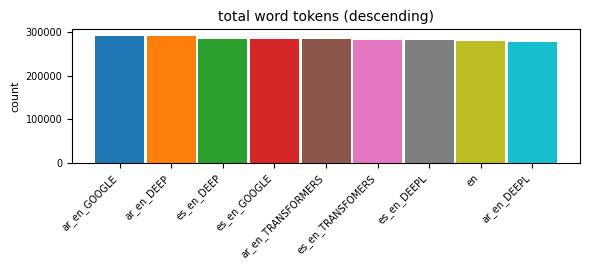

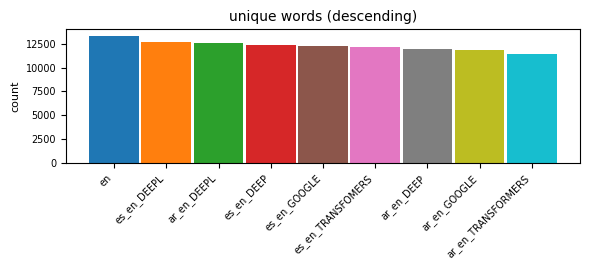

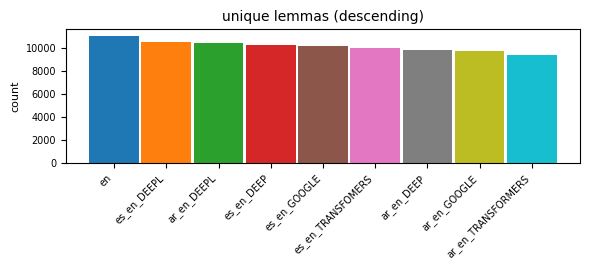

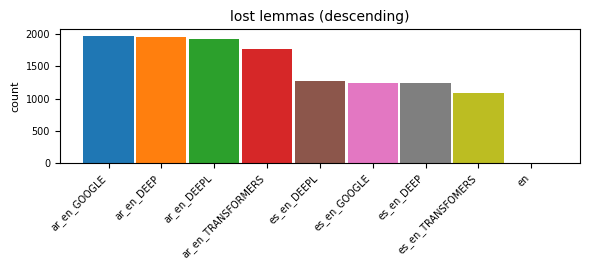

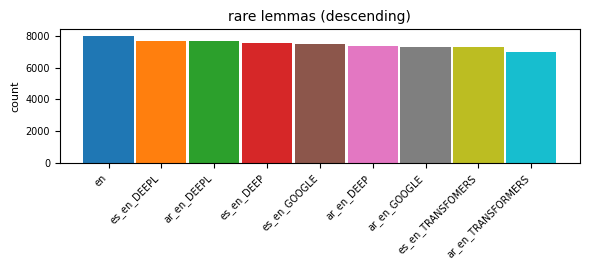

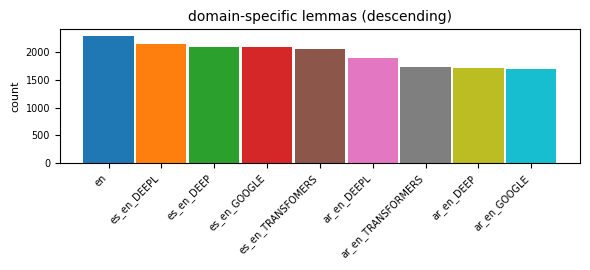

In [6]:
# %%
#B.L. compact bar-charts with contiguous, colour-coded bars
#B.L. load the stanza summary
summary_path = "summary_statistics_stanza.csv"
if not os.path.isfile(summary_path):
    raise FileNotFoundError("summary_statistics_stanza.csv not found")
summary = pd.read_csv(summary_path)

#B.L. metrics to visualise
metrics = [
    ("total_tokens",        "total word tokens"),
    ("unique_words",        "unique words"),
    ("unique_lemmas",       "unique lemmas"),
    ("lost_lemmas",         "lost lemmas"),
    ("rare_unique_lemmas",  "rare lemmas"),
    ("domain_unique_lemmas","domain-specific lemmas"),
]

#B.L. colour palette – one distinct colour per MT column
palette = plt.cm.get_cmap("tab10", len(summary))

#B.L. common bar settings
bar_w   = 0.95               # bars almost full width → they touch
figsize = (6, 2.8)

for key, title in metrics:
    ordered = summary.sort_values(key, ascending=False).reset_index(drop=True)
    x       = np.arange(len(ordered))
    
    fig, ax = plt.subplots(figsize=figsize)
    ax.bar(
        x,
        ordered[key],
        width=bar_w,
        color=[palette(i) for i in range(len(ordered))],
        edgecolor="none",
    )
    
    ax.set_title(title + " (descending)", fontsize=10)
    ax.set_ylabel("count", fontsize=8)
    ax.set_xticks(x)
    ax.set_xticklabels(ordered["column"], rotation=45, ha="right", fontsize=7)
    ax.tick_params(axis="y", labelsize=7)
    
    plt.tight_layout()
    plt.show()


# %of lost lemmas compared to the total number of unique lemmas for each column (stanza)

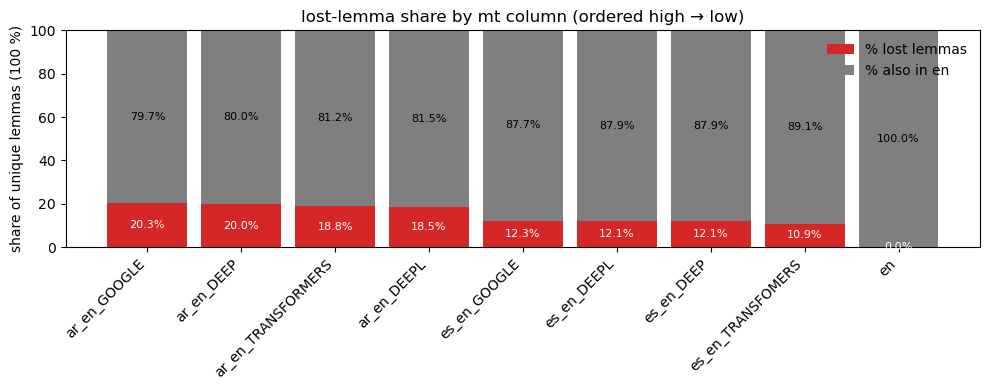

In [7]:
#B.L. load stanza summary or raise error
summary_path = "summary_statistics_stanza.csv"
if not os.path.isfile(summary_path):
    raise FileNotFoundError("summary_statistics_stanza.csv must be in the working folder.")
summary = pd.read_csv(summary_path)

#B.L. compute lost percentage and complement
summary["pct_lost"] = summary["lost_lemmas"] / summary["unique_lemmas"] * 100
summary["pct_keep"] = 100 - summary["pct_lost"]

#B.L. order rows by lost percentage descending
ordered = summary.sort_values("pct_lost", ascending=False).reset_index(drop=True)

#B.L. stacked bar data
x = np.arange(len(ordered))
lost = ordered["pct_lost"].values
keep = ordered["pct_keep"].values

fig, ax = plt.subplots(figsize=(10, 4))

#B.L. stacked bars
bars_lost = ax.bar(x, lost, width=0.85, label="% lost lemmas", color="tab:red")
bars_keep = ax.bar(x, keep, width=0.85, bottom=lost, label="% also in en", color="tab:gray")

#B.L. add numeric labels (one decimal) centered in each segment
for i, (l, k) in enumerate(zip(lost, keep)):
    ax.text(i, l / 2, f"{l:.1f}%", ha="center", va="center", color="white", fontsize=8)
    ax.text(i, l + k / 2, f"{k:.1f}%", ha="center", va="center", color="black", fontsize=8)

#B.L. formatting
ax.set_xticks(x)
ax.set_xticklabels(ordered["column"], rotation=45, ha="right")
ax.set_ylim(0, 100)
ax.set_ylabel("share of unique lemmas (100 %)")
ax.set_title("lost-lemma share by mt column (ordered high → low)")
ax.legend(frameon=False)
plt.tight_layout()

plt.show()


# Visualisation (Stanza) based on lost lemmas / (domain-specific/rare)

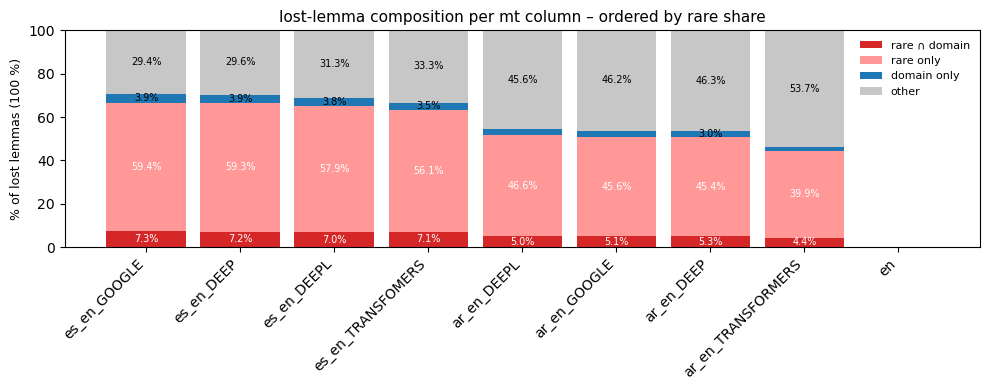

In [8]:
# %%
#B.L. 100 % stacked bar of lost-lemma mix, ordered by rare share,

#B.L. load stanza summary
summary_path = "summary_statistics_stanza.csv"
if not os.path.isfile(summary_path):
    raise FileNotFoundError("summary_statistics_stanza.csv must be in the working folder.")
summary = pd.read_csv(summary_path)

#B.L. compute four mutually-exclusive slices for every column
slices = []
rare_share = []               #B.L. to sort by
for _, row in summary.iterrows():
    both        = row["lost_lemmas_rare_domain"]
    rare_only   = row["lost_lemmas_rare"]   - both
    domain_only = row["lost_lemmas_domain"] - both
    other       = row["lost_lemmas"]        - (both + rare_only + domain_only)
    slices.append((both, rare_only, domain_only, other))

    #B.L. safe rare share (avoid zero divide)
    if row["lost_lemmas"] > 0:
        share = (rare_only + both) / row["lost_lemmas"] * 100
    else:
        share = 0
    rare_share.append(share)

slices     = np.array(slices)                         # shape (n_cols, 4)
rare_share = np.array(rare_share)

#B.L. reorder rows by descending rare share
order        = rare_share.argsort()[::-1]
summary_ord  = summary.iloc[order].reset_index(drop=True)
slices_ord   = slices[order]

#B.L. stacked-bar prep
labels  = ["rare ∩ domain", "rare only", "domain only", "other"]
colors  = ["#d62728", "#ff9896", "#1f77b4", "#c7c7c7"]

x       = np.arange(len(summary_ord))
width   = 0.85
bottom  = np.zeros(len(summary_ord))

fig, ax = plt.subplots(figsize=(10, 4))

for idx, (lab, col) in enumerate(zip(labels, colors)):
    pct = np.where(
        summary_ord["lost_lemmas"] > 0,
        100 * slices_ord[:, idx] / summary_ord["lost_lemmas"],
        0,
    )
    bars = ax.bar(x, pct, width, bottom=bottom, label=lab, color=col, edgecolor="none")

    #B.L. annotate if slice > 3 %
    for bar, val in zip(bars, pct):
        if val > 3:
            ax.text(
                bar.get_x() + bar.get_width() / 2,
                bar.get_y() + bar.get_height() / 2,
                f"{val:.1f}%",
                ha="center",
                va="center",
                fontsize=7,
                color="white" if idx < 2 else "black",
            )
    bottom += pct

#B.L. axes and styling
ax.set_xticks(x)
ax.set_xticklabels(summary_ord["column"], rotation=45, ha="right")
ax.set_ylim(0, 100)
ax.set_ylabel("% of lost lemmas (100 %)", fontsize=9)
ax.set_title("lost-lemma composition per mt column – ordered by rare share", fontsize=11)
ax.legend(frameon=False, fontsize=8)
plt.tight_layout()
plt.show()


# Visualisation (SpaCy) based on all words (comparison btw different mt tools and language pairs)

C:\Users\brike\AppData\Local\Temp\ipykernel_12452\1370495486.py:20: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  palette = plt.cm.get_cmap("tab10", len(summary))


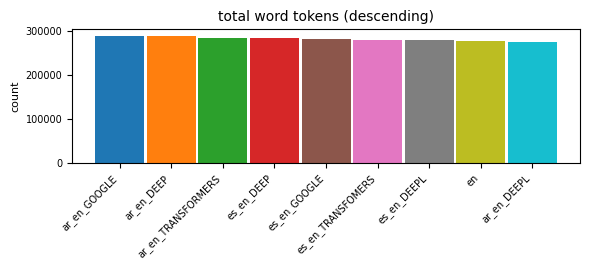

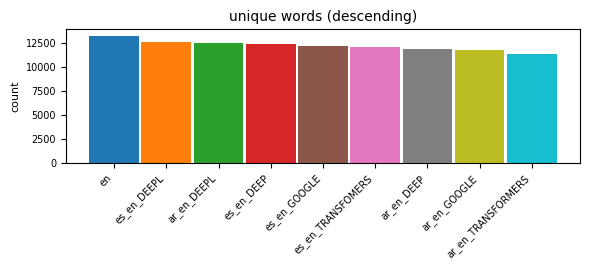

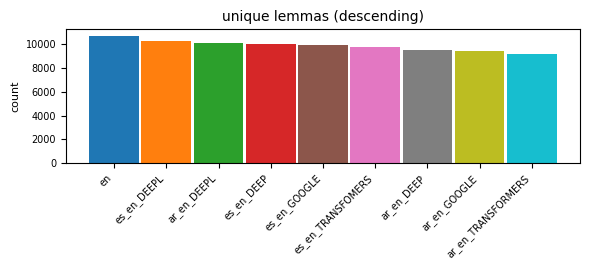

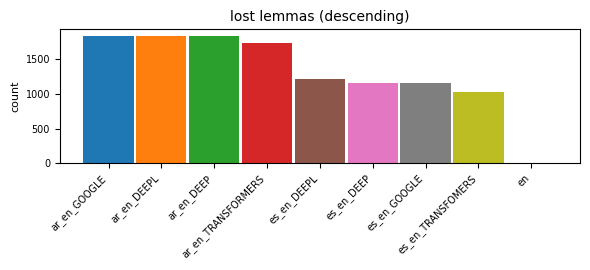

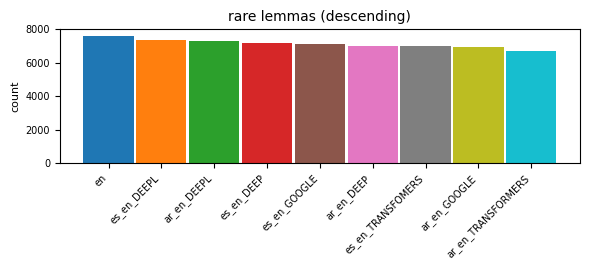

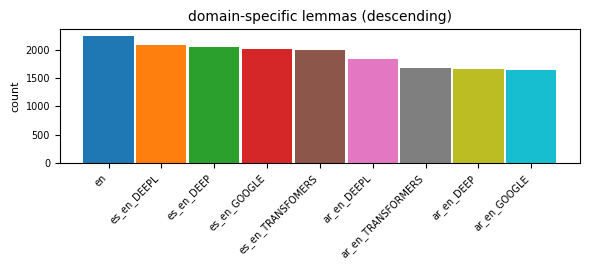

In [9]:
# %%
#B.L. compact bar-charts with contiguous, colour-coded bars
#B.L. load the stanza summary
summary_path = "summary_statistics_spacy.csv"
if not os.path.isfile(summary_path):
    raise FileNotFoundError("summary_statistics_spacy.csv not found")
summary = pd.read_csv(summary_path)

#B.L. metrics to visualise
metrics = [
    ("total_tokens",        "total word tokens"),
    ("unique_words",        "unique words"),
    ("unique_lemmas",       "unique lemmas"),
    ("lost_lemmas",         "lost lemmas"),
    ("rare_unique_lemmas",  "rare lemmas"),
    ("domain_unique_lemmas","domain-specific lemmas"),
]

#B.L. colour palette – one distinct colour per MT column
palette = plt.cm.get_cmap("tab10", len(summary))

#B.L. common bar settings
bar_w   = 0.95               # bars almost full width
figsize = (6, 2.8)

for key, title in metrics:
    ordered = summary.sort_values(key, ascending=False).reset_index(drop=True)
    x       = np.arange(len(ordered))
    
    fig, ax = plt.subplots(figsize=figsize)
    ax.bar(
        x,
        ordered[key],
        width=bar_w,
        color=[palette(i) for i in range(len(ordered))],
        edgecolor="none",
    )
    
    ax.set_title(title + " (descending)", fontsize=10)
    ax.set_ylabel("count", fontsize=8)
    ax.set_xticks(x)
    ax.set_xticklabels(ordered["column"], rotation=45, ha="right", fontsize=7)
    ax.tick_params(axis="y", labelsize=7)
    
    plt.tight_layout()
    plt.show()


# %of lost lemmas compared to the total number of unique lemmas for each column (SpaCy)

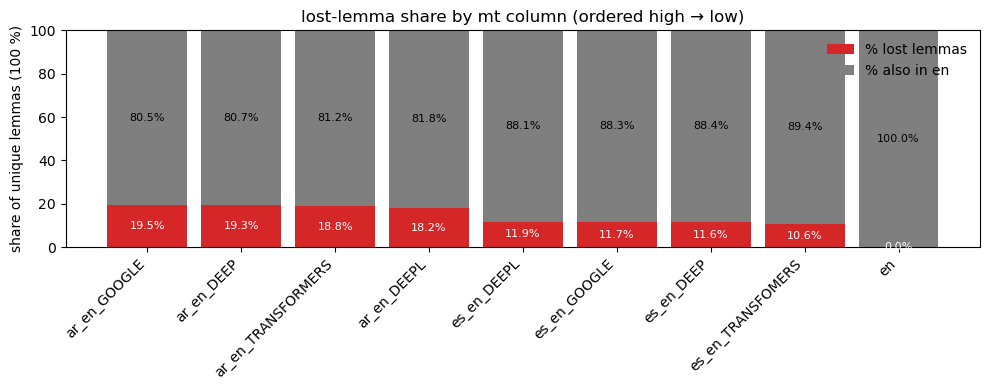

In [10]:
#B.L. load stanza summary or raise error
summary_path = "summary_statistics_spacy.csv"
if not os.path.isfile(summary_path):
    raise FileNotFoundError("summary_statistics_spacy.csv must be in the working folder.")
summary = pd.read_csv(summary_path)

#B.L. compute lost percentage and complement
summary["pct_lost"] = summary["lost_lemmas"] / summary["unique_lemmas"] * 100
summary["pct_keep"] = 100 - summary["pct_lost"]

#B.L. order rows by lost percentage descending
ordered = summary.sort_values("pct_lost", ascending=False).reset_index(drop=True)

#B.L. stacked bar data
x = np.arange(len(ordered))
lost = ordered["pct_lost"].values
keep = ordered["pct_keep"].values

fig, ax = plt.subplots(figsize=(10, 4))

#B.L. stacked bars
bars_lost = ax.bar(x, lost, width=0.85, label="% lost lemmas", color="tab:red")
bars_keep = ax.bar(x, keep, width=0.85, bottom=lost, label="% also in en", color="tab:gray")

#B.L. add numeric labels (one decimal) centered in each segment
for i, (l, k) in enumerate(zip(lost, keep)):
    ax.text(i, l / 2, f"{l:.1f}%", ha="center", va="center", color="white", fontsize=8)
    ax.text(i, l + k / 2, f"{k:.1f}%", ha="center", va="center", color="black", fontsize=8)

#B.L. formatting
ax.set_xticks(x)
ax.set_xticklabels(ordered["column"], rotation=45, ha="right")
ax.set_ylim(0, 100)
ax.set_ylabel("share of unique lemmas (100 %)")
ax.set_title("lost-lemma share by mt column (ordered high → low)")
ax.legend(frameon=False)
plt.tight_layout()

plt.show()


# Visualisation (SpaCy) based on lost lemmas / (domain-specific/rare)

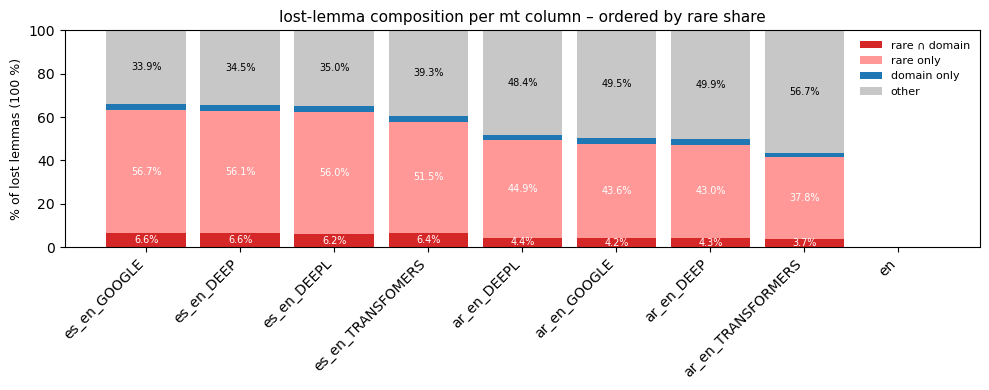

In [11]:
# %%
#B.L. 100 % stacked bar of lost-lemma mix, ordered by rare share,
#B.L. load spacy summary
summary_path = "summary_statistics_spacy.csv"
if not os.path.isfile(summary_path):
    raise FileNotFoundError("summary_statistics_spacy.csv must be in the working folder.")
summary = pd.read_csv(summary_path)

#B.L. compute four mutually-exclusive slices for every column
slices = []
rare_share = []               #B.L. to sort by
for _, row in summary.iterrows():
    both        = row["lost_lemmas_rare_domain"]
    rare_only   = row["lost_lemmas_rare"]   - both
    domain_only = row["lost_lemmas_domain"] - both
    other       = row["lost_lemmas"]        - (both + rare_only + domain_only)
    slices.append((both, rare_only, domain_only, other))

    #B.L. safe rare share (avoid zero divide)
    if row["lost_lemmas"] > 0:
        share = (rare_only + both) / row["lost_lemmas"] * 100
    else:
        share = 0
    rare_share.append(share)

slices     = np.array(slices)                         # shape (n_cols, 4)
rare_share = np.array(rare_share)

#B.L. reorder rows by descending rare share
order        = rare_share.argsort()[::-1]
summary_ord  = summary.iloc[order].reset_index(drop=True)
slices_ord   = slices[order]

#B.L. stacked-bar prep
labels  = ["rare ∩ domain", "rare only", "domain only", "other"]
colors  = ["#d62728", "#ff9896", "#1f77b4", "#c7c7c7"]

x       = np.arange(len(summary_ord))
width   = 0.85
bottom  = np.zeros(len(summary_ord))

fig, ax = plt.subplots(figsize=(10, 4))

for idx, (lab, col) in enumerate(zip(labels, colors)):
    pct = np.where(
        summary_ord["lost_lemmas"] > 0,
        100 * slices_ord[:, idx] / summary_ord["lost_lemmas"],
        0,
    )
    bars = ax.bar(x, pct, width, bottom=bottom, label=lab, color=col, edgecolor="none")

    #B.L. annotate if slice > 3 %
    for bar, val in zip(bars, pct):
        if val > 3:
            ax.text(
                bar.get_x() + bar.get_width() / 2,
                bar.get_y() + bar.get_height() / 2,
                f"{val:.1f}%",
                ha="center",
                va="center",
                fontsize=7,
                color="white" if idx < 2 else "black",
            )
    bottom += pct

#B.L. axes and styling
ax.set_xticks(x)
ax.set_xticklabels(summary_ord["column"], rotation=45, ha="right")
ax.set_ylim(0, 100)
ax.set_ylabel("% of lost lemmas (100 %)", fontsize=9)
ax.set_title("lost-lemma composition per mt column – ordered by rare share", fontsize=11)
ax.legend(frameon=False, fontsize=8)
plt.tight_layout()
plt.show()


# Compare the results of the two pipelines

Absolute difference (spacy - stanza) for shared metrics:



,column,total_tokens,unique_words,unique_lemmas,rare_unique_lemmas,domain_unique_lemmas,lost_lemmas,lost_lemmas_rare,lost_lemmas_domain,lost_lemmas_rare_domain
0,en,-414,-45,-317,-374,-43,0,0,0,0
1,es_en_DEEP,-561,6,-234,-334,-50,-77,-95,-28,-12
2,es_en_DEEPL,-283,17,-228,-321,-61,-57,-70,-28,-14
3,es_en_GOOGLE,-1015,-30,-265,-353,-59,-90,-100,-31,-15
4,es_en_TRANSFOMERS,-204,12,-190,-323,-43,-57,-91,-21,-12


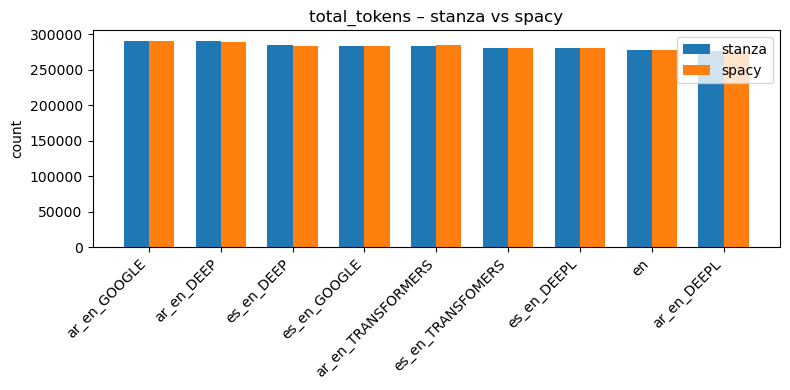

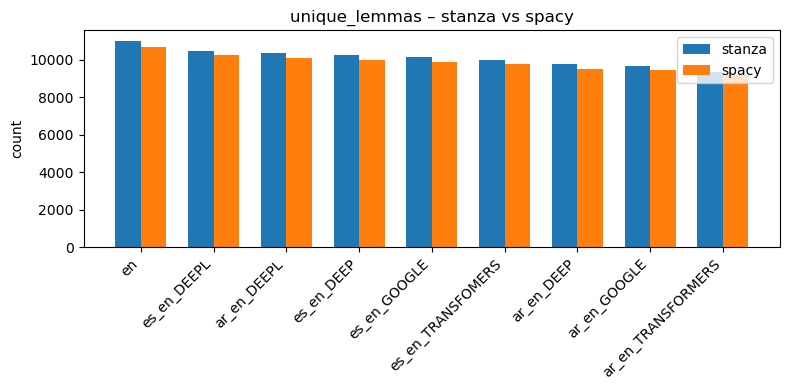

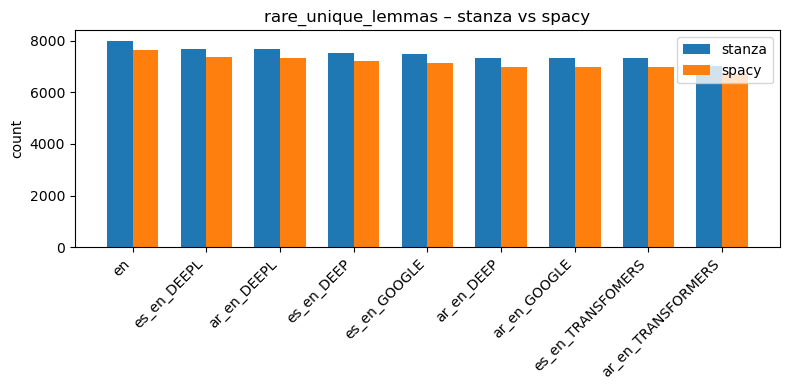

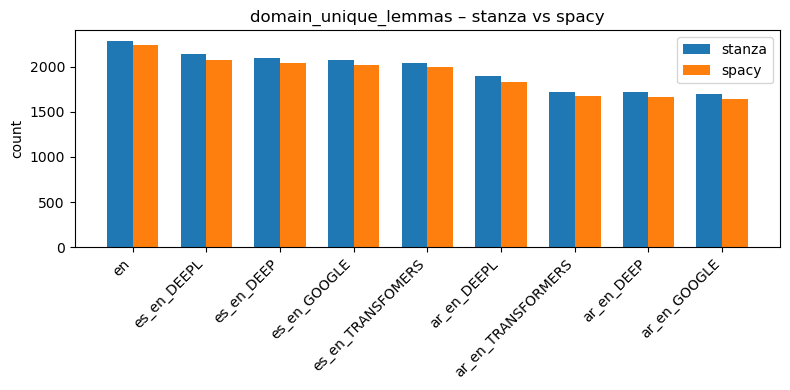

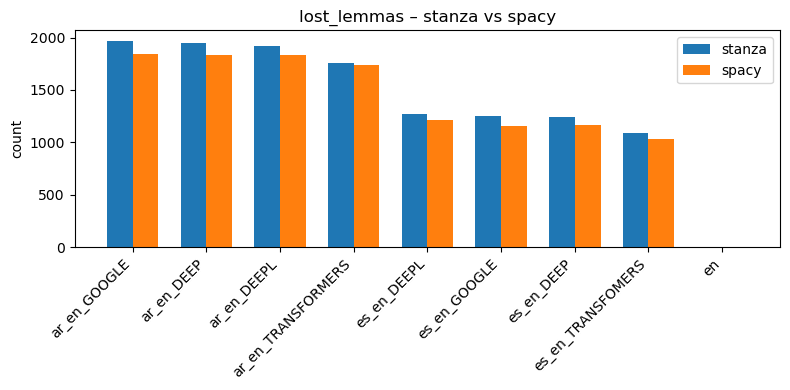

In [12]:
#B.L. load summary files for stanza and spacy; raise if missing
stanza_file = "summary_statistics_stanza.csv"
spacy_file  = "summary_statistics_spacy.csv"

for f in (stanza_file, spacy_file):
    if not os.path.isfile(f):
        raise FileNotFoundError(f"{f} not found in working directory.")

stanza = pd.read_csv(stanza_file).set_index("column")
spacy  = pd.read_csv(spacy_file).set_index("column")

#B.L. keep only columns present in both summaries
common_metrics = stanza.columns.intersection(spacy.columns)
stanza = stanza[common_metrics]
spacy  = spacy[common_metrics]

#B.L. concatenate with a new axis level to identify pipeline
combined = pd.concat(
    {"stanza": stanza, "spacy": spacy},
    axis=1,
)

#B.L. compute absolute difference (spacy minus stanza) for quick inspection
diff = spacy - stanza
diff = diff.reset_index()

display_cols = ["column"] + list(diff.columns[1:])
diff = diff[display_cols]

print("Absolute difference (spacy - stanza) for shared metrics:\n")
display(diff.head())

#B.L. pick a subset of key metrics for visual comparison
key_metrics = [
    "total_tokens",
    "unique_lemmas",
    "rare_unique_lemmas",
    "domain_unique_lemmas",
    "lost_lemmas",
]

#B.L. for each metric, draw grouped bars (stanza vs spacy) ordered by stanza value
for metric in key_metrics:
    ordered_cols = stanza[metric].sort_values(ascending=False).index.tolist()
    stanza_vals = stanza.loc[ordered_cols, metric]
    spacy_vals  = spacy.loc[ordered_cols, metric]

    x = np.arange(len(ordered_cols))
    width = 0.35

    fig, ax = plt.subplots(figsize=(8, 4))
    ax.bar(x - width/2, stanza_vals, width, label="stanza", color="tab:blue")
    ax.bar(x + width/2, spacy_vals,  width, label="spacy",  color="tab:orange")

    ax.set_xticks(x)
    ax.set_xticklabels(ordered_cols, rotation=45, ha="right")
    ax.set_title(f"{metric} – stanza vs spacy")
    ax.set_ylabel("count")
    ax.legend()
    plt.tight_layout()
    plt.show()


# comparison of the results with the manual ones which have data cleaned manually


absolute difference (spacy − stanza)

                    unique_words  unique_lemmas  rare_unique_lemmas  domain_unique_lemmas  lost_lemmas  lost_lemmas_rare  lost_lemmas_domain  lost_lemmas_rare_domain
column                                                                                                                                                               
ar_en_DEEP                   -26           -245                -348                   -50         -117              -120                 -33                      -24
ar_en_DEEPL                  -13           -253                -341                   -65          -78               -83                 -25                      -15
ar_en_GOOGLE                 -29           -248                -336                   -51         -127              -119                 -33                      -24
ar_en_TRANSFORMERS             2           -151                -282                   -43          -24               -58           

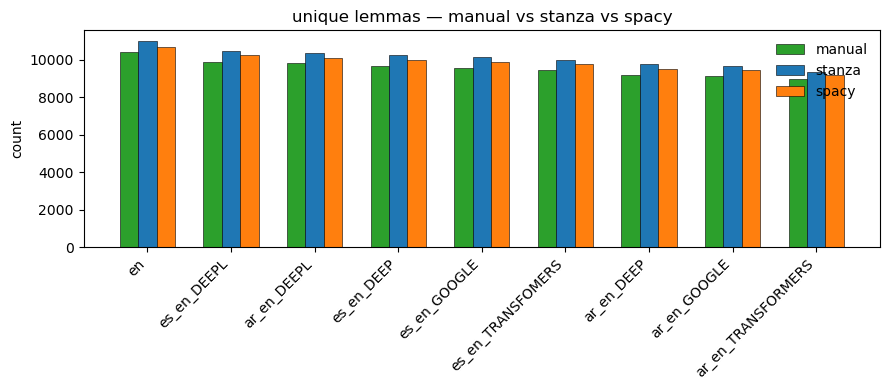

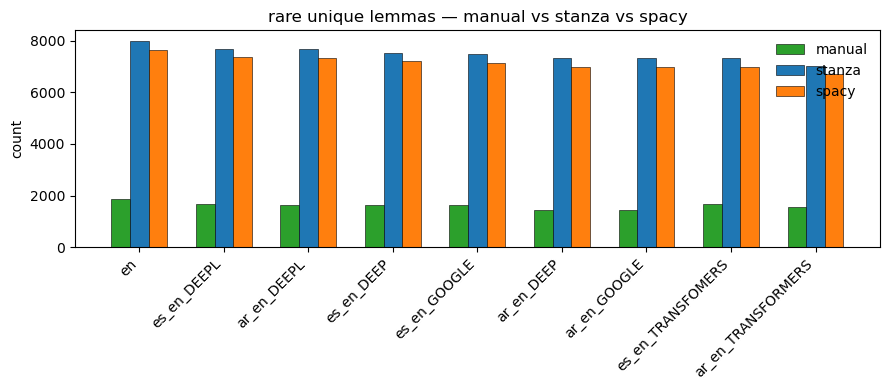

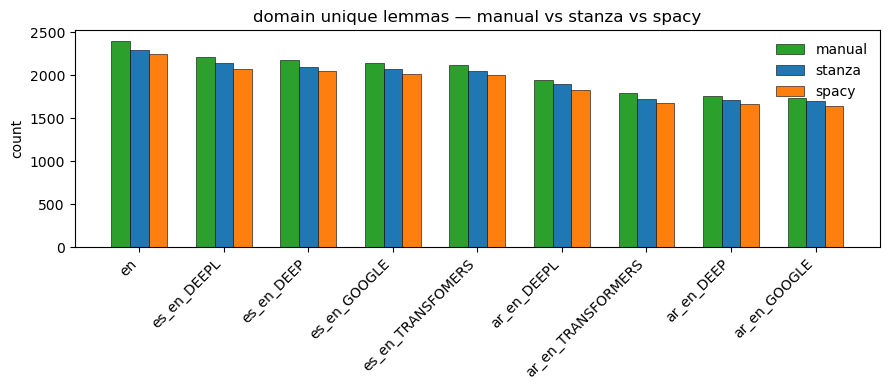

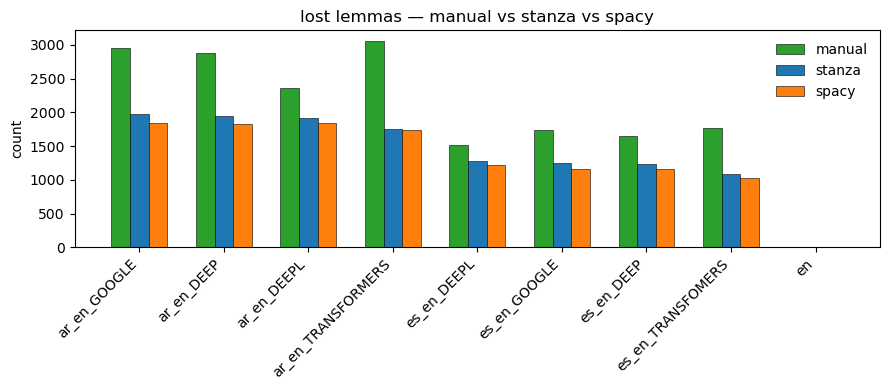

In [15]:
# %%
#B.L. three-way comparison (manual vs automatic: stanza / spacy)
#B.L. column-name harmonisation

import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import os

#B.L. 1) table from the manual annotations (relationship not included)
manual_data = {
    "column": [
        "en",
        "es_en_DEEP", "es_en_DEEPL", "es_en_GOOGLE", "es_en_TRANSFOMERS",
        "ar_en_DEEP", "ar_en_DEEPL", "ar_en_GOOGLE", "ar_en_TRANSFORMERS",
    ],
    #B.L. manual table values
    "total_unique_words":      [13020, 12072, 12336, 11965, 11802, 11610, 12156, 11464, 11128],
    "total_unique_lemmas":     [10403,  9673,   9885,  9571,   9466,   9199,   9811,   9154,   8954],
    "rare_unique_lemmas":      [ 1856,  1644,   1685,  1621,   1666,   1445,   1641,   1435,   1564],
    "domain_unique_lemmas":    [ 2401,  2174,   2209,  2143,   2116,   1758,   1939,   1736,   1794],
    "lost_lemmas":             [    0,  1643,   1520,  1744,   1766,   2882,   2355,   2948,   3064],
    "lost_lemmas_rare":        [    0,   286,    285,   299,    297,    983,    848,   1002,    963],
    "lost_lemmas_domain":      [    0,   304,    277,   330,    342,    766,    573,    785,    696],
    "lost_lemmas_rare_domain": [    0,    89,     83,    89,     86,    408,    309,    413,    349],
}
manual = pd.DataFrame(manual_data).set_index("column")


#B.L. 2) load the previous statistics
stanza_file = "summary_statistics_stanza.csv"
spacy_file  = "summary_statistics_spacy.csv"

for f in (stanza_file, spacy_file):
    if not os.path.isfile(f):
        raise FileNotFoundError(f"{f} missing – generate the summary first.")

stanza = pd.read_csv(stanza_file).set_index("column")
spacy  = pd.read_csv(spacy_file).set_index("column")


#B.L. 3) harmonise column names to the automatic ones
rename_map = {
    #B.L. manual → canonical
    "total_unique_words":  "unique_words",
    "total_unique_lemmas": "unique_lemmas",
    #B.L. pipeline already uses canonical names
}

manual = manual.rename(columns=rename_map)

canonical_metrics = [
    "unique_words",
    "unique_lemmas",
    "rare_unique_lemmas",
    "domain_unique_lemmas",
    "lost_lemmas",
    "lost_lemmas_rare",
    "lost_lemmas_domain",
    "lost_lemmas_rare_domain",
]

#B.L. restrict to the canonical metric list
manual = manual[canonical_metrics]
stanza = stanza[canonical_metrics]
spacy  = spacy[canonical_metrics]


#B.L. 4) concatenate with source labels
combined = pd.concat(
    {"manual": manual, "stanza": stanza, "spacy": spacy},
    axis=1,
).sort_index()

#B.L. 5) print numerical differences
abs_diff = combined["spacy"] - combined["stanza"]
pct_diff = abs_diff / combined["stanza"] * 100

print("\nabsolute difference (spacy − stanza)\n")
print(abs_diff.to_string())

print("\npercentage difference (spacy − stanza)\n")
print(pct_diff.round(2).astype(str) + " %")

#B.L. 6) grouped-bar charts for a few key metrics
key_metrics = [
    "unique_lemmas",
    "rare_unique_lemmas",
    "domain_unique_lemmas",
    "lost_lemmas",
]

palette = {"manual": "tab:green", "stanza": "tab:blue", "spacy": "tab:orange"}
bar_w   = 0.22

for metric in key_metrics:
    order = stanza[metric].sort_values(ascending=False).index
    x     = np.arange(len(order))
    
    fig, ax = plt.subplots(figsize=(9, 4))
    for i, src in enumerate(("manual", "stanza", "spacy")):
        vals = combined[src, metric].loc[order]
        ax.bar(
            x + (i - 1) * bar_w,
            vals,
            bar_w,
            label=src,
            color=palette[src],
            edgecolor="black",
            linewidth=0.4,
        )
    
    ax.set_xticks(x)
    ax.set_xticklabels(order, rotation=45, ha="right")
    ax.set_title(f"{metric.replace('_', ' ')} — manual vs stanza vs spacy")
    ax.set_ylabel("count")
    ax.legend(frameon=False)
    plt.tight_layout()
    plt.show()
